# Initial Training
Borrowing a model I know works to verify my training pipeline.

In this notebook, I train a model on a single image to see if it will learn to
generate it from random noise after training.

Spoiler: yes it works. See last cell for an example.

In [1]:
import sys
sys.path.append("../")

from udl_module.nn import DiffusionNoiser

import lightning as L
import torch
from torch import nn

from torchvision import transforms
from PIL import Image

import math
import matplotlib.pyplot as plt

seed = 1967
torch.manual_seed(seed)

## Model from a tutorial
I will use the model from [this tutorial](https://github.com/Jackson-Kang/Pytorch-Diffusion-Model-Tutorial/blob/main/01_denoising_diffusion_probabilistic_model.ipynb) as a baseline, because I can't yet be sure if the U-Net I defined actually is sound.

Sinusoidal embedding for diffusion timestep

In [2]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In this tutorial, we use a simple stacked-convolution model with various dilations instead of UNet-like architecture.

In [3]:
class ConvBlock(nn.Conv2d):
    """
        Conv2D Block
            Args:
                x: (N, C_in, H, W)
            Returns:
                y: (N, C_out, H, W)
    """

    def __init__(self, in_channels, out_channels, kernel_size, activation_fn=None, drop_rate=0.,
                    stride=1, padding='same', dilation=1, groups=1, bias=True, gn=False, gn_groups=8):
        
        if padding == 'same':
            padding = kernel_size // 2 * dilation

        super(ConvBlock, self).__init__(in_channels, out_channels, kernel_size,
                                            stride=stride, padding=padding, dilation=dilation,
                                            groups=groups, bias=bias)

        self.activation_fn = nn.SiLU() if activation_fn else None
        self.group_norm = nn.GroupNorm(gn_groups, out_channels) if gn else None
        
    def forward(self, x, time_embedding=None, residual=False):
        
        if residual:
            # in the paper, diffusion timestep embedding was only applied to residual blocks of U-Net
            x = x + time_embedding
            y = x
            x = super(ConvBlock, self).forward(x)
            y = y + x
        else:
            y = super(ConvBlock, self).forward(x)
        y = self.group_norm(y) if self.group_norm is not None else y
        y = self.activation_fn(y) if self.activation_fn is not None else y
        
        return y

In [4]:
class Denoiser(nn.Module):
    
    def __init__(self, image_resolution, hidden_dims=[256, 256], diffusion_time_embedding_dim = 256, n_times=1000):
        super(Denoiser, self).__init__()
        
        _, _, img_C = image_resolution
        
        self.time_embedding = SinusoidalPosEmb(diffusion_time_embedding_dim)
        
        self.in_project = ConvBlock(img_C, hidden_dims[0], kernel_size=7)
        
        self.time_project = nn.Sequential(
                                 ConvBlock(diffusion_time_embedding_dim, hidden_dims[0], kernel_size=1, activation_fn=True),
                                 ConvBlock(hidden_dims[0], hidden_dims[0], kernel_size=1))
        
        self.convs = nn.ModuleList([ConvBlock(in_channels=hidden_dims[0], out_channels=hidden_dims[0], kernel_size=3)])
        
        for idx in range(1, len(hidden_dims)):
            self.convs.append(ConvBlock(hidden_dims[idx-1], hidden_dims[idx], kernel_size=3, dilation=3**((idx-1)//2),
                                                    activation_fn=True, gn=True, gn_groups=8))                                
                               
        self.out_project = ConvBlock(hidden_dims[-1], out_channels=img_C, kernel_size=3)
        
        
    def forward(self, perturbed_x, diffusion_timestep):
        y = perturbed_x
        
        diffusion_embedding = self.time_embedding(diffusion_timestep)
        diffusion_embedding = self.time_project(diffusion_embedding.unsqueeze(-1).unsqueeze(-2))
        
        y = self.in_project(y)
        
        for i in range(len(self.convs)):
            y = self.convs[i](y, diffusion_embedding, residual = True)
            
        y = self.out_project(y)
            
        return y

## Getting the dataset
Copying this from an earlier experiment I did

In [5]:
# Loading a single image as a torch tensor
img_size = 32 # 128
img_path = "slimste_test_image.jpg"
img = Image.open(img_path)
img: torch.Tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])
])(img)

print(f"{img.shape=}, {img.min()=}, {img.max()=}, {img.mean()=}")

img.shape=torch.Size([3, 32, 32]), img.min()=tensor(-1.), img.max()=tensor(0.9902), img.mean()=tensor(-0.2943)


In [6]:
# Creating a dataset for a single datapoint
from torch.utils.data import IterableDataset, DataLoader

class SingleImgDataSet(IterableDataset):

    def __init__(self, img: torch.Tensor):
        super().__init__()
        self.img = img
    
    def __iter__(self):
        while True:
            yield self.img

dataset = SingleImgDataSet(img)
dataloader = DataLoader(
    dataset, 128, num_workers=4
)

## Training the model
Using PyTorch Lightning to create the training loop

In [18]:
class DiffusionModel(L.LightningModule):

    def __init__(   self,
                    model: nn.Module,
                    optimizer_cls: torch.optim.Optimizer = torch.optim.Adam,
                    optimizer_args: dict = dict(),
                    steps: int = 1000,
                    beta_start: float = 1e-4,
                    beta_end: float = 0.02
                 ):
        """
        Args:
            model: the underlying denoising architecture (typically a U-Net). It
                should take a batch of noisy images and integer time values as
                input to the `forward` method.
            optimizer_cls: the class type of the optimizer
            optimizer_args: the args (other than params) to give the optimizer
                at init.
            steps: number of noising steps to use
            beta_start: the initial value for beta (linear interpolation)
            beta_end: the final value of beta (linear interpolation)
        """
        super().__init__()
        self.model = model
        self.optimizer_cls = optimizer_cls
        self.optimizer_args = optimizer_args
        self.noiser = DiffusionNoiser(steps, beta_start, beta_end)
    
    def forward(self, x, t):
        return self.model(x, t)
    
    def training_step(self, batch, batch_idx):
        noise = torch.randn_like(batch)
        ts = torch.randint(0, len(self.noiser.betas), (len(batch),), device=batch.device)
        noised_img = self.noiser.closed_form_noise(batch, noise, ts)

        noise_hat = self.model(noised_img, ts)

        loss = nn.functional.mse_loss(noise_hat, noise)
        self.log("train/mse", loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return self.optimizer_cls(self.parameters(), *self.optimizer_args)
    
    @torch.inference_mode()
    def sample_img(self, shape: tuple[int]):
        """Samples from a train diffusion model.
        
        Args:
            shape: the shape of the element or batch [(B x) C x W x H]
        """
        self.eval()
        noisy_img = torch.randn(shape, device=self.device)
        steps = len(self.noiser.betas)
        for idx in reversed(range(steps)):
            t = torch.tensor([idx], device=self.device)
            predicted_noise = self(noisy_img, t)
            new_noise = torch.randn_like(noisy_img)
            noisy_img = self.noiser.denoising_step(noisy_img, predicted_noise, t, new_noise)
        return noisy_img

In [19]:
# Setting up the trainer
trainer = L.Trainer(
    max_time={"minutes": 5},
    enable_checkpointing=False,
    logger=False,
    enable_progress_bar=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [20]:
n_layers = 8
hidden_dim = 256
hidden_dims = [hidden_dim for _ in range(n_layers)]
timestep_embedding_dim = 256
n_timesteps = 1000
beta_minmax=[1e-4, 2e-2]

model = Denoiser(image_resolution=(32,32,3),
                 hidden_dims=hidden_dims,
                 diffusion_time_embedding_dim=timestep_embedding_dim,
                 n_times=n_timesteps)

# noiser = DiffusionNoiser()

diffusion_model = DiffusionModel(model)

In [ ]:
trainer.fit(diffusion_model, dataloader)

## Doing inference
Seeing how well I can denoise my image with the model, or even generate the
image from random noise completely.

In [22]:
diffusion_model.eval();

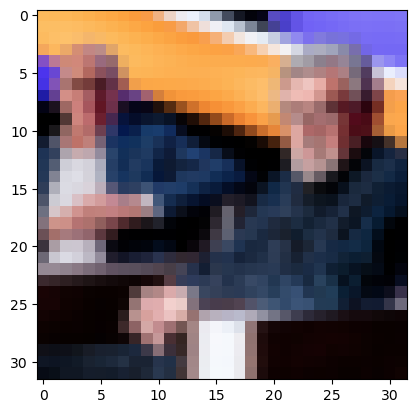

In [23]:
def plot_img(img: torch.Tensor):
    plt.imshow(img.permute(1, 2, 0) * 0.5 + 0.5)
    plt.show()

plot_img(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.65733385..1.4919568].


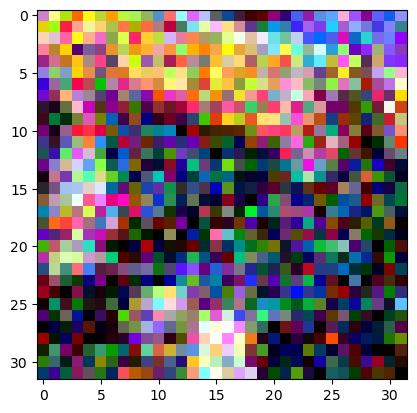

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.077798724..1.1650431].


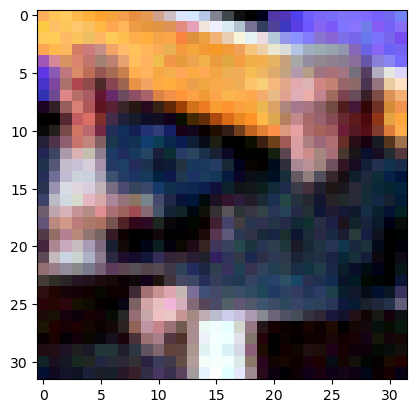

In [ ]:
with torch.inference_mode():
    # Generating a random sample:
    t = torch.randint(0, 1000, (1,))
    noise = torch.randn_like(img)
    noisy_img = diffusion_model.noiser.closed_form_noise(img, noise, t)

    # Predicting the noise using our model:
    predicted_noise = diffusion_model(noisy_img, t).squeeze()
    predicted_img = diffusion_model.noiser.img_from_closed_form_noise(noisy_img, predicted_noise, t)

plot_img(noisy_img)
plot_img(predicted_img.detach())

Now doing a full diffusion run

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.010926634..1.1118555].


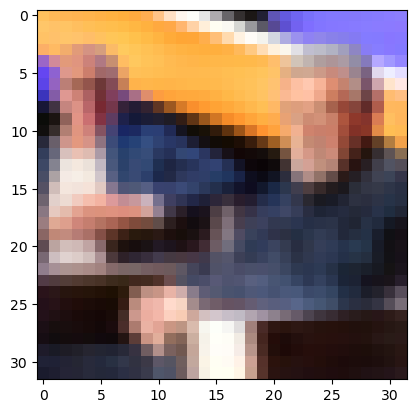

In [ ]:
diffusion_model.to("cuda")

# We trained on one image, so sampling should give us that one image:
noisy_img = diffusion_model.sample_img(img.shape)

plot_img(noisy_img.squeeze().cpu().detach())

## It works! :-)